Often described as "the categorical analogue to PCA", Correspondence Analysis is a dimension-reduction technique that describes the relationship and distribution between two categorical variables.

Reading papers on the topic proved to be needlessly dense and uninformative-- my lightbulb moment on this topic came when I stumbled across Francois Husson's [fantastic tutorial series on YouTube](https://www.youtube.com/watch?v=Z5Lo1hvZ9fA). 100% worth the watch and is where I'll pull many of my images from.

## Intuition

For starters, this analysis assumes that our data is prepared as a cross-tabulation of two categorical variables. In the illustration below, there are `L` records, each with two categorical variables. This leads to a cross-tab matrix with all `I` distinct `V_1` variables as rows and `J` distinct `V_2` variables as columns.

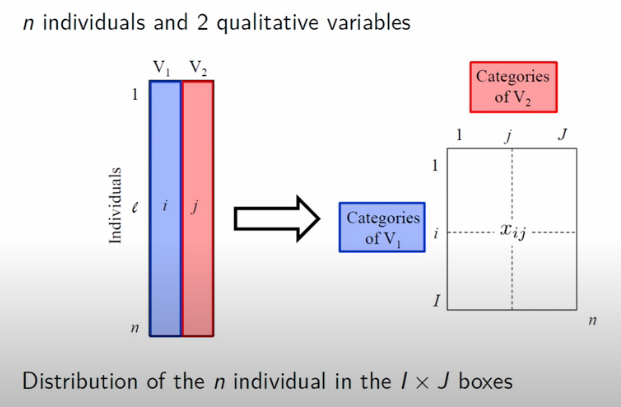

In [1]:
from IPython.display import Image
Image('images/ca_data.PNG')

More concretely, the dataset that Francois uses looks at the distribution of Nobel Prize wins by Category and Country

In [2]:
import pandas as pd

df = pd.read_csv('nobel_data.csv', index_col='Country')
df

,Chemistry,Economics,Literature,Medicine,Peace,Physics
Country,,,,,,
Canada,4,3,2,4,1,4
France,8,3,11,12,10,9
Germany,24,1,8,18,5,24
Italy,1,1,6,5,1,5
Japan,6,0,2,3,1,11
Russia,4,3,5,2,3,10
UK,23,6,7,26,11,20
USA,51,43,8,70,19,66


### Conditional Probabilities

Unpacking further, the explanation that finally stuck for me was deeply rooted in conditional probability. Here, the row, column, and total sums play a crucial role in computation. This allows us to start expressing conditional probabilities, predicated on overall counts (for this, he uses notation that I've never seen before, as I've highlighted below)

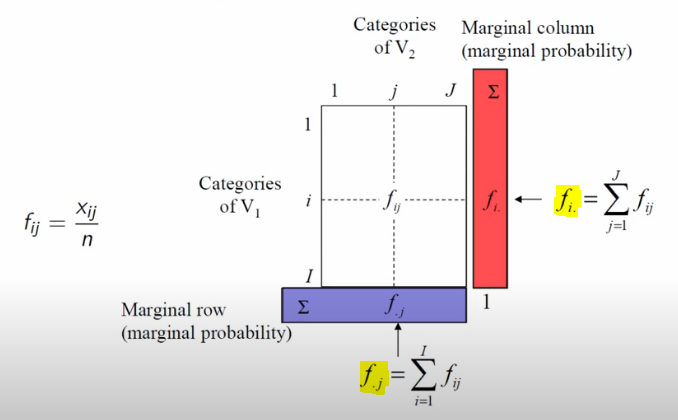

In [3]:
Image('images/ca_probs.PNG')

Ultimately, the core mechanic of Correspondence Analysis is an examination of how much our data deviates from an assumption of complete independence. This is a direct extension of [the Chi Squared Test](https://napsterinblue.github.io/notes/stats/basics/chi_squared/).

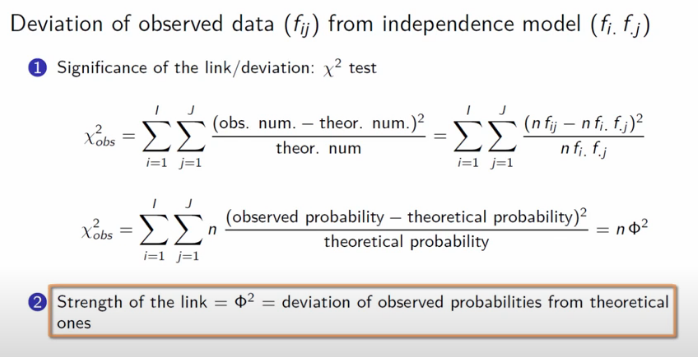

In [4]:
Image('images/ca_chi_sq.PNG')

In the context of a cross-tab, if our variables all had independence, we'd assume that the values in our rows would be distributed consistently with the proportion of the totals, and similarly for the columns.

These two graphics do a fantastic job representing this notion. For example, we can see that `Italy` has a `Literature` proportion way off of the mean row value, and `Economics` prizes are disproportionally won by people from the `US`.

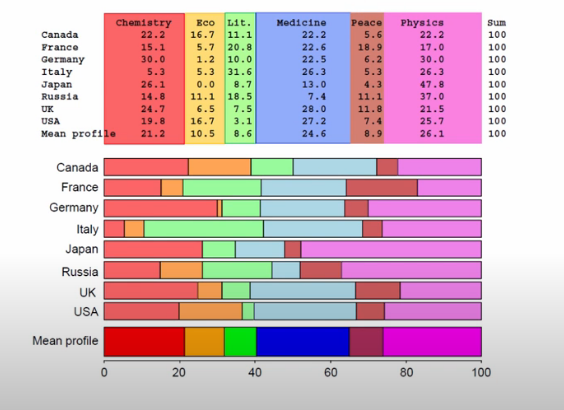

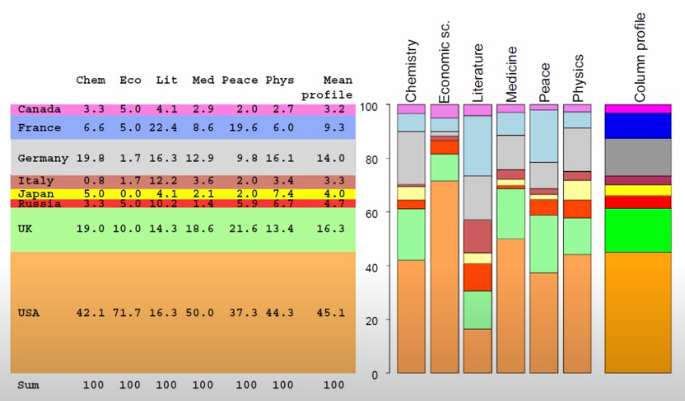

In [5]:
display(Image('images/ca_row_profile.PNG'))

display(Image('images/ca_col_profile.PNG'))

Bringing it home, we can then plot all of the conditional probabilities into a point cloud.

The point `G` represents the center of gravity for the cloud.

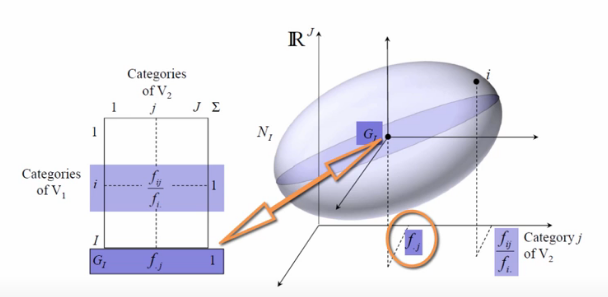

In [6]:
display(Image('images/ca_row_cloud.PNG'))

However, `G` has a neater intuitive meaning. In the case that our data is all independent, all of the points will just sink to the center of gravity and it will be point, not a point *cloud*.

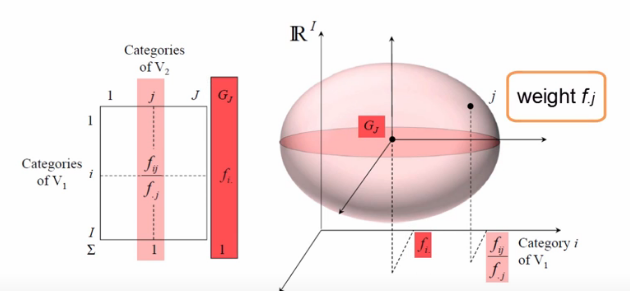

In [7]:
display(Image('images/ca_col_cloud.PNG'))

The fact that we instead represent all of the conditional probabilities with a cloud, however, means that there is some measure of deviation from the origin, `G`. We call this the **interia** of the point cloud.

To restate: *Intertia measures the deviation from independence.*

Finally, the whole purpose of Correspondence Analysis is to get our data to this point and then find the orthogonal projections that explain the most inertia.

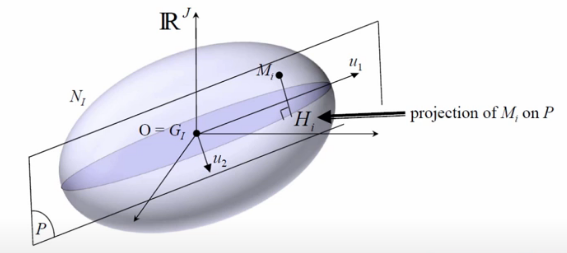

In [8]:
Image('images/ca_max_intertia.PNG')

[Now where have we heard this before?](https://napsterinblue.github.io/notes/stats/techniques/pca/)

### Translating

The two point-clouds are generated from the same dataset, so it stands to reason that there should be some way to translate from one to the other, yeah?

For this, Correspondence Analysis borrows a $2 word from astrophysics, called *barycenter*, which is basically the center of mass between arbitrarily-many objects. Per wikipedia, in the `n=2` case, where the red `+` is the barycenter:

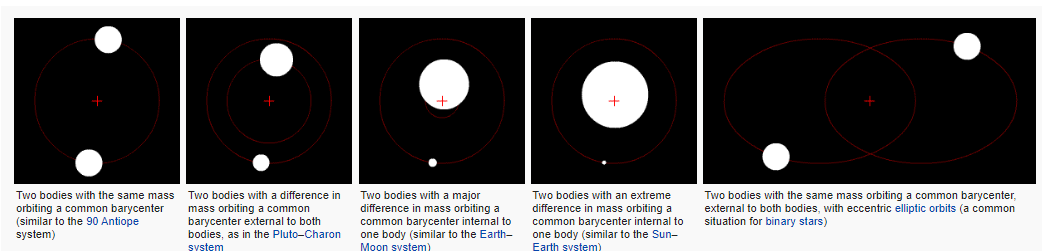

In [9]:
Image('images/barycenter.PNG')

As it relates to our usecase, the barycenter of a row on a given axis can be thought of as a weighted average of the column representation.

For a given derived axis `s`, the columnar representation `G(j)` is weighted by the sum of all conditional probabilities across those columns, then finally scaled by the `lambda` value for that axis (more on this below).

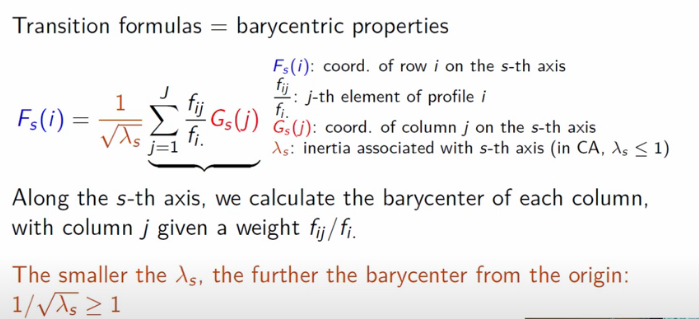

In [10]:
Image('images/ca_barycenters.PNG')

This is a bit of a mouthful to take in, but this allows us two nice properties:

- The reverse is true-- we can swap the `G` and `F` terms and this still works
- Because of this, when we the rows and columns in the new space defined by the various `s` axes, the rows are closest to columns that it's most associated and vice-versa.

### Relationship to SVD

As mentioned above, the literature on Correspondence Analysis is (in my estimation) needlessly dense. For example, [this pdf](http://statmath.wu.ac.at/courses/CAandRelMeth/caipA.pdf) begins 

>CA is based on fairly straightforward, classical results in matrix theory

and makes a real hurry of throwing a lot of Greek at you. I might come back and revise this notebook, but for the time being, I think Francois' explanation is all the know-how we're going to need on this matter, save for "how do we actually find the axes?"

For this, first refer to my [notes on SVD](https://napsterinblue.github.io/notes/stats/lin_alg/understanding_svd/).

Then grabbing a small chunk of the equations they throw at you, I want to highlight two things:

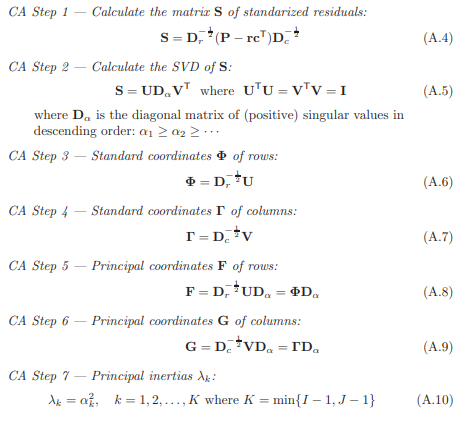

In [11]:
Image('images/ca_paper.PNG')

We get the following for free:

- `N` and `n` represent the crosstab matrix and total counts
- These are used to build a simple matrix of probabilities `P`
- `r` and `c` represent the row and column proportions, which both add to `1`
- `D_r` and `D_c` are the diagonal matrices of the row and column spaces

And so it looks like equations `A.8-10` are the nuts and bolts of representing our newfound axes `s`. Moreover, it looks like we can get this if we can get the values in `A.6-7`, which in turn need values `U` and `V`, which are typical results of doing SVD, in `A.5`.

The trick to all of is answering "SVD on *what*?" For which, we can cleverly construct a matrix, `S`, of standardized residuals. Once that sentence makes sense to you, you can close the pdf. Residuals should make you think of error, and error should mean difference between predicted and observed, and as mentioned "predicted" actually means "the assumption that everything just follows the population distribution, `P`.

Armed with that intuition, `S` becomes the key used to unlock the rest. Of course, there's a handy Python package to keep all of this math straight for us.

## On Our Dataset

So running CA on the dataset above, Francois plots out the points from the cross-tab, relative to the new axes he found.

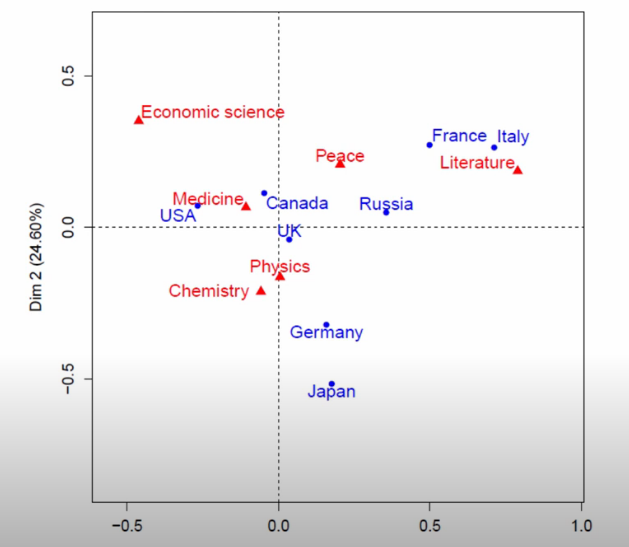

In [12]:
Image('images/ca_scatter.PNG')

The first thing he points is distance to center of the scatter plot.

Broadly-speaking, this is a good proxy for "how dissimilar to 'everything follows the same distribution'".

For example, `UK` is basically on the axis, and we can see below that the distribution of awards won looks VERY close to the sample distribution. `Italy`, on the other hand, has won dramatically more of the green aand is thus far-flung from the origin.

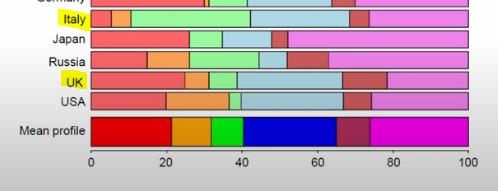

In [13]:
Image('images/ca_uk_zoomed.PNG')

Similarly, the `Economics` prizes seem disproportionally won by the `US` (orange), so it's pretty far off-origin. However, the `US` *does* seem to win a respectable proportion of the prizes in each category.

A better example to look at is `Italy` (teal). On average, they make up a tiny speck of overall awards, but because they're a good 20% of the `Literature` prize winners, their point is the furthest-right of the whole shebang.

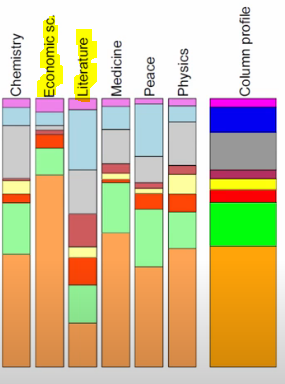

In [14]:
Image('images/ca_econ_zoomed.PNG')

## Metrics

### Eigenvalues and Explained Inertia

So after we find our othogonal axes that best-span the point cloud, the eigenvalues that we find represent the explained Inertia of a given axis

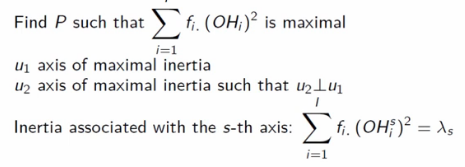

In [15]:
Image('images/ca_eigen_value.PNG')

Then, because our axes are orthogonal, we can add the eigenvalues together and divide by the total inertia to get a look at how well an axis captures the overall spread of our point-cloud

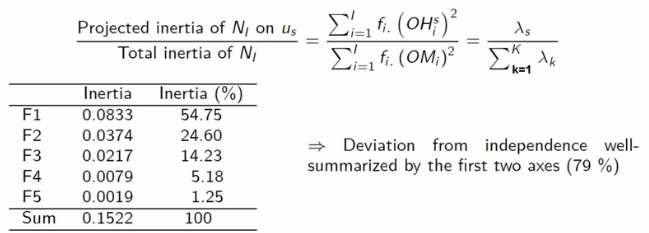

In [16]:
Image('images/ca_avg_inertia.PNG')

An eigenvalue equaling `1` means that it accounts for a perfect separation between two blocks in the data. As a toy example, Francois cooks up a small table of taste profiles. The rows are whether a tasted sample *was* sweet, sour, or bitter. The columns are how they were percieved by tasters.

The first CA-generated axis helps separate our data into two distinct groups, "Sweet" and "Maybe sour or bitter", with perfect accuracy.

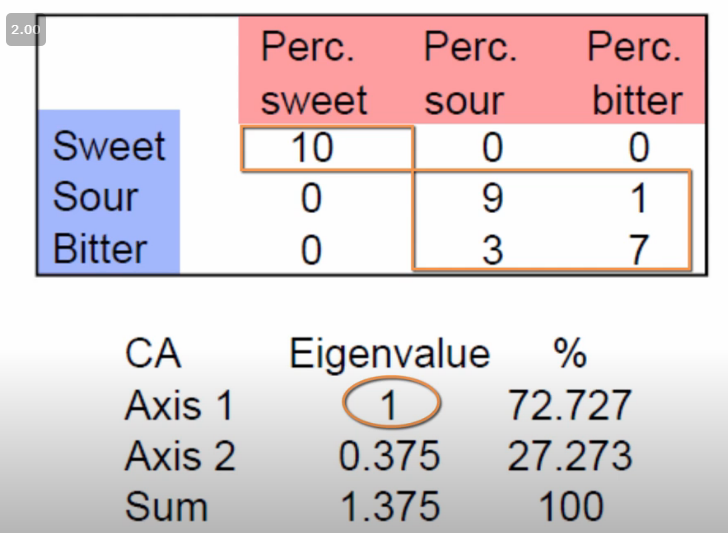

In [17]:
Image('images/ca_eigen_val_is_one.PNG')

On the other hand, let's look at two slightly-adjusted version of the dataset. The second axis should help us determine the difference between sour and bitter.

The data on the left is better-separated than the one on the right, and thus the `Axis 2` eigenvalue is higher and the points scattered are more spread apart.

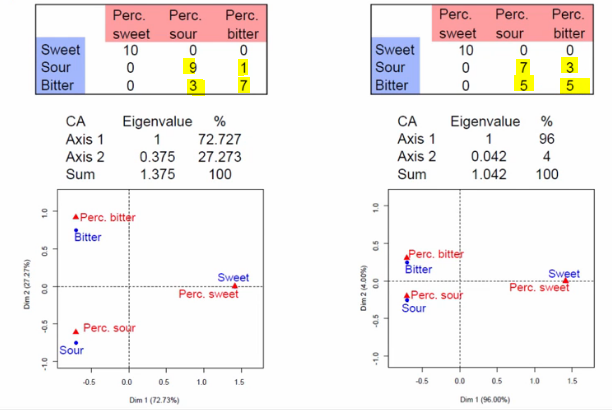

In [18]:
Image('images/ca_eigen_val_isnt_one.PNG')

### Total Explained Inertia

This intuition in mind, when we revisit the Nobel dataset, two things stand out:

- The explained inertia for the first axis is far less than 1, so there's no straight-forward cut in the data
- The total explained inertia is much less than `5` (a heuristic value, I suppose), so the data isn't as well-separated as we might have thought at first glance.

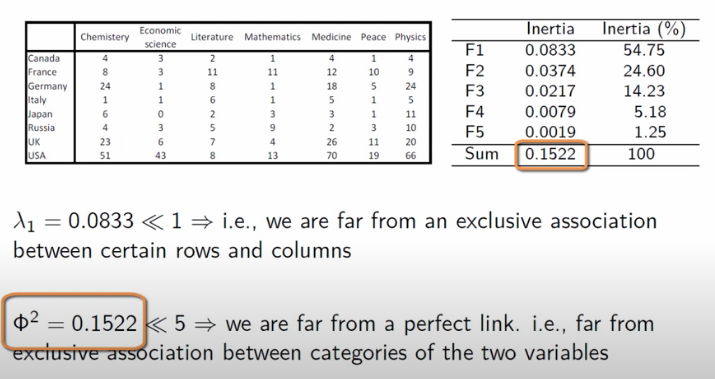

In [19]:
Image('images/ca_revisit_nobel.PNG')

## In Python

Correspondence Analysis is made pretty simple by the `prince` library.

Continuing with our original dataset, we'll follow a workflow similar to what we'd do in `sklearn`

In [20]:
from prince import CA

ca = CA(n_components=2)

ca.fit(df)

CA(benzecri=False, check_input=True, copy=True, engine='auto', n_components=2,
   n_iter=10, random_state=None)

we've deconstructed the countries into two principal components and can see a good deal of separation.

Populating the interactive namespace from numpy and matplotlib


,0,1
Canada,0.047235,-0.113463
France,-0.498328,-0.273206
Germany,-0.158403,0.319637
Italy,-0.712666,-0.265207
Japan,-0.175512,0.515635
Russia,-0.356149,-0.048568
UK,-0.035672,0.040835
USA,0.267488,-0.071423


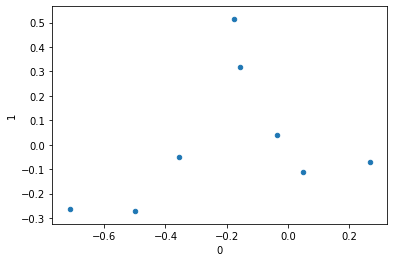

In [21]:
%pylab inline

display(ca.row_coordinates(df))
ca.row_coordinates(df).plot.scatter(0, 1);

similarly, we can look at how the columns are mapped in this new space.

,0,1
Chemistry,0.058167,0.211959
Economics,0.461605,-0.351199
Literature,-0.789820,-0.185986
Medicine,0.107692,-0.066187
Peace,-0.203421,-0.207777
Physics,-0.004938,0.163765


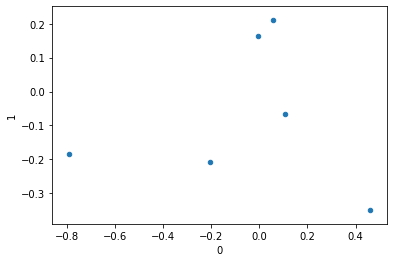

In [22]:
display(ca.column_coordinates(df))
ca.column_coordinates(df).plot.scatter(0, 1);

But even cooler, it's super easy to plot the two together via the expressive `plot_coordinates()` function. This looks like the images we've been looking at all along, just flipped across a couple axes.

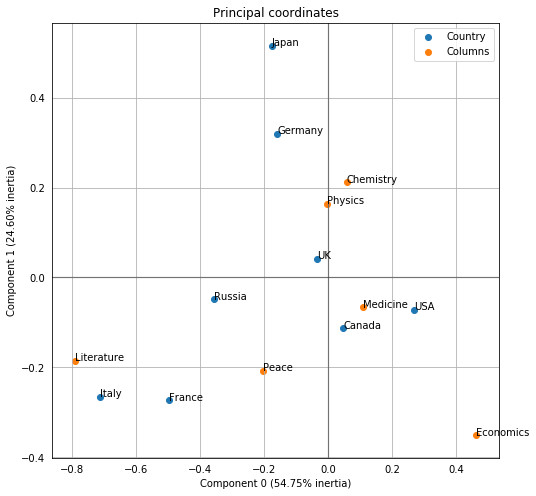

In [23]:
ca.plot_coordinates(df,
                    figsize=(8, 8));

Finally, we can easily inspect the various metrics that we want to pay attention to.

In [24]:
ca.eigenvalues_

[0.08333122262451487, 0.03744306648476863]

In [25]:
ca.total_inertia_

0.1522091104308082

In [26]:
ca.explained_inertia_

[0.5474785470374054, 0.24599753837855615]